In [21]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import control as ct

# Linear-Quadratic Regulator (LQR)
---

LQR es una técnica en donde es posible ubicar los polos del sistema en un lugar especifico para lograr un desempeńo deseado. Esto se realiza de una forma muy similar a lo visto en Pole Placement, aplicando una ganancia K en la realimentación. Sin embargo, en LQR se optimizan las ganancias para encontrar la relación deseada entre el esfuerzo y el desempeño del sistema.




 Imaginemos un ejemplo ilustrativo. Suponga que debe trasladarse a la universidad utilizando diferentes metodos de transporte, donde con cada uno tardará un tiempo $t$ (desempeño), pero con un precio asociado (esfuerzo).

 
|           | Tiempo (minutos) | Precio (Miles de pesos) |
|:---------:|:----------------:|:-----------:|
| Bicicleta |        30        |      0      |
| Automovil |        20        |    15    |
|    Bus    |        45        |     2.75    |


¿Cúal sería la mejor forma de llegar a la universidad?

**Depende**. La respuesta varía dependiendo de que queremos priorizar. 

Si tomamos una función de coste total $J$:

$$J = Q*tiempo + R*Precio$$

Donde Q y R son las prioriodades que se les da a cada una de las variables del sistema, por ejemplo, si quisieramos priorizar (penalizar) el precio sobre el tiempo, tendríamos los siguientes resultados:

$Q=1, R=2$


|           | Tiempo (minutos) | Coste (Miles de pesos) |   J   |
|:---------:|:----------------:|:-----------:|:-----:|
| Bicicleta |        30        |      0      |   30  |
| Automovil |        20        |    15       | 50    |
|    Bus    |        45        |     2.75    |  50.5 |

En este caso, el metodo de transporte optimo sería la bicicleta. Si por el contrario penalizamos el tiempo:

$Q = 2, R=1$

|           | Tiempo (minutos) | Coste (Miles de pesos) |   J   |
|:---------:|:----------------:|:----------------------:|:-----:|
| Bicicleta |        30        |            0           |   60  |
| Automovil |        20        |           15           |   55  |
|    Bus    |        45        |          2.75          | 92.75 |

De esta forma, el metodo optimo sería el automovil


Aplicado en sistemas dinámicos, podemos establecer $Q$ como una matriz cuadrada donde en la diagonal esta el coste de cada una de las variables del sistema, mientras que $R$ es tambien una matriz diagonal con el coste de cada una de las entradas al sistema. De esta manera, podemos definir la función de coste como:

$$J = \int_0^\infty (x^TQx + u^TRu)$$

De esta forma, se podemos plantear un problema de optimización donde encontremos las constantes K tal que minimicen la función de coste.

# Ejemplo con UNMotorDC
---

Podemos realizar varios experimentos con diferentes parametros de $Q$ y $R$ para comparar los resultados en el desempeño y la energía utilizada en el sistema

## Modelo en espacio de estados de un motor DC

El modelo en variables de estado lo podemos definir como:

* \dot{\theta}: Velocidad Angular (rad\s)
* $L_A$: Inductancia de la armadura (H)
* $R_A$: Resistencia de la armadura (\Omega)
* B: Constante de fricción viscosa del motor
* N: Relación de engranajes del reductor
* J: Momento de inercia del motor (Nm)
* $\mu$: Relación lineal entre torque y corriente



$$x = 
\begin{bmatrix}
-R_A/L_A & -\mu/L_A\\
\mu/JN & -B/JN
\end{bmatrix}
\begin{bmatrix}
i \\
\dot{\theta} 
\end{bmatrix}
+
\begin{bmatrix}
1/L_A \\
0 
\end{bmatrix} V
$$

$$
y = \begin{bmatrix}
0 & 1
\end{bmatrix}
\begin{bmatrix}
i \\
\dot{\theta}
\end{bmatrix}
$$

In [28]:
# Constantes del motor
B = 0.1 # Fricción
J = 0.01 
N = 10
mu = 0.01 
La = 0.5 
Ra = 1 

# Modelo en espacio de estados
A = np.asarray([[-Ra/La, -mu/La],[mu/(J*N), -B/(J*N)]])
B = np.asarray([[1/La],[0]])
C = np.asarray([0, 1])
D = 0

system = ct.ss(A, B, C, D)

## Establecer Q y R

Para este sistema, podemos definir la matriz $Q$ de la forma:

$$Q=
\begin{bmatrix}
\textit{Coste de la corriente} & 0\\
0 & \textit{Coste de la velocidad angular}
\end{bmatrix}
$$

Mientras que $R$ representa el coste del voltaje, para este sistema es un valor escalar.

## LQR en python
---

In [29]:
# funciones utiles
def simulate_system(lqr_sys, K_lqr, max_time=10):
    t = np.linspace(0, max_time, max_time*10)  # Tiempo de simulación
    step_input = np.ones_like(t)
    _, y, x = ct.forced_response(lqr_sys, T=t, U=step_input, return_x=True)
    u = step_input-K_lqr @ x
    
    return y, u, t
    

def lqr_system(sys, Q, R):
    K_lqr, S, E = ct.lqr(sys, Q, R)
    Acl = A - B @ K_lqr
    lqr_sys = ct.ss(Acl, B, C, D)
    return lqr_sys, K_lqr


## Comparación del rendimiento con diferentes valores de $Q$ y $R$

FloatSlider(value=1.0, continuous_update=False, description='Velocidad:', max=10.0, min=1e-05, readout_format=…

FloatSlider(value=1.0, continuous_update=False, description='Corriente:', max=10.0, min=1e-05, readout_format=…

FloatSlider(value=1.0, continuous_update=False, description='Voltaje:', max=10.0, min=1e-05, readout_format='.…

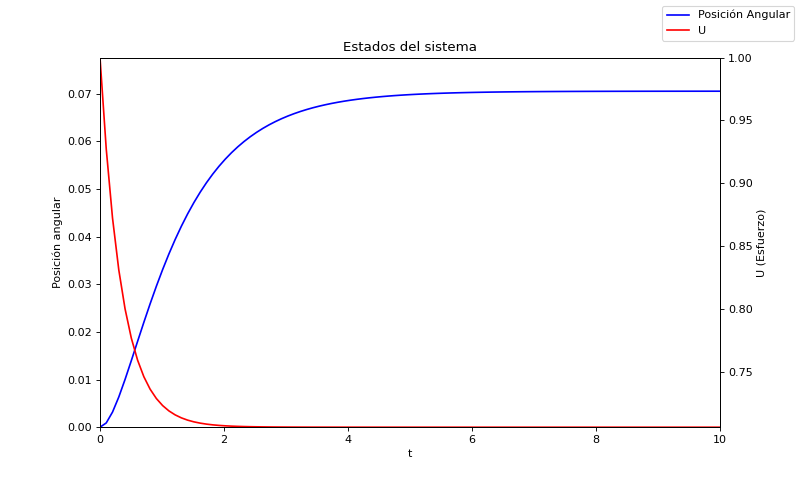

In [34]:
# Funciones para interacción con las graficas

# Configuración de sliders

Speed = widgets.FloatSlider(
    value=1, min=0.00001, max=10.0, step=0.00001,
    description='Velocidad:', continuous_update=False, readout_format='.4f'
)

Current = widgets.FloatSlider(
    value=1, min=0.00001, max=10.0, step=0.00001,
    description='Corriente:', continuous_update=False, readout_format='.4f'
)

Voltage = widgets.FloatSlider(
    value=1, min=0.00001, max=10.0, step=0.00001,
    description='Voltaje:', continuous_update=False, readout_format='.4f'
)

# Inicializar la figura
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=80)

# Definir las líneas que se actualizarán
line_y, = ax1.plot([], [], label='Posición Angular', color="blue")
ax1.set_title("Estados del sistema")
ax1.set_xlabel("t")
ax1.set_ylabel("Posición angular")

ax2 = ax1.twinx()
line_u, = ax2.plot([], [], label='U', color="red")
ax2.set_xlabel("t")
ax2.set_ylabel("U (Esfuerzo)")
fig.legend()

# Función de actualización
def update(val=0):
    Q_diag = np.diag([Current.value, Speed.value])
    R_vec = np.asarray([[Voltage.value]])
    lqr_sys, K_lqr = lqr_system(system, Q_diag, R_vec)
    y, u, t = simulate_system(lqr_sys, K_lqr, 10)
    
    # Actualizar datos de las líneas
    line_y.set_data(t, y)
    line_u.set_data(t, u.T)
    
    # Ajustar los límites del gráfico
    ax1.set_xlim(t[0], t[-1])
    ax1.set_ylim(min(y)*1.1, max(y)*1.1)
    ax2.set_ylim(min(u.T), max(u.T))
    
    fig.canvas.draw_idle()

# Mostrar sliders
display(Speed, Current, Voltage)

# Observadores para sliders
Speed.observe(update, names='value')
Current.observe(update, names='value')
Voltage.observe(update, names='value')

# Llamar a update para iniciar la gráfica
update()